import libaraies

In [6]:
import os, random, cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

#deepLearning Libraries
import keras.backend as k
from keras.models import Model, Sequential
from keras.layers import Input, Dense, Flatten, Dropout, BatchNormalization
from keras.layers import Conv2D, SeparableConv2D, MaxPool2D, LeakyReLU, Activation
from keras.models import load_model
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
import tensorflow as tf

Set the seeds for reproduciblity

In [7]:
seed = 232
np.random.seed(seed)

Show sample of the data

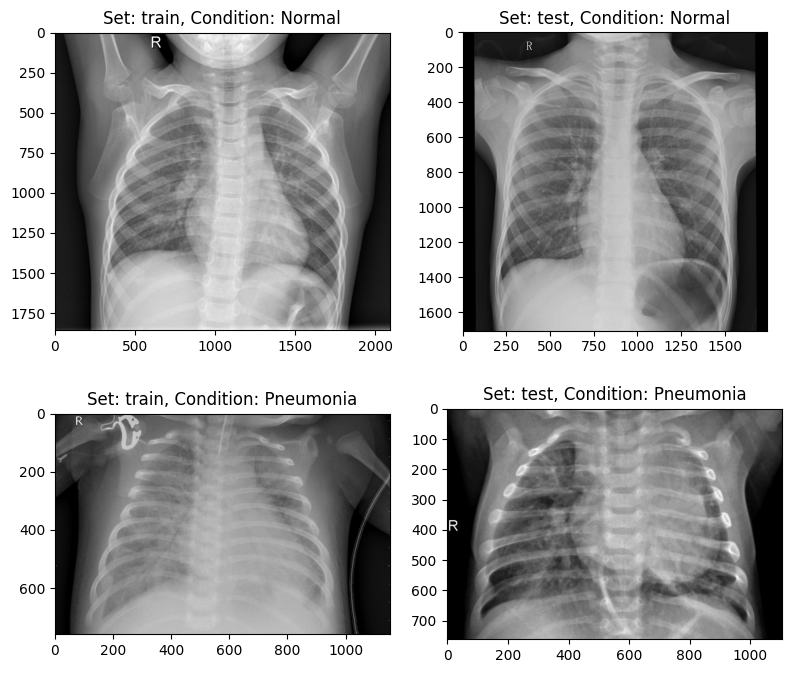

In [8]:
input_path = 'chest_xray/'
fig, ax = plt.subplots(2, 2, figsize=(8, 7))
ax = ax.ravel()
plt.tight_layout()
for i, _set in enumerate(['train', 'test']):
    set_path = input_path+_set
    ax[i].imshow(plt.imread(set_path+'/NORMAL/'+os.listdir(set_path+'/NORMAL')[0]), cmap='gray')
    ax[i].set_title('Set: {}, Condition: Normal'.format(_set))
    ax[i+2].imshow(plt.imread(set_path+'/PNEUMONIA/'+os.listdir(set_path+'/PNEUMONIA')[0]), cmap='gray')
    ax[i+2].set_title('Set: {}, Condition: Pneumonia'.format(_set))
plt.show()

Distrbution of our dataset

In [9]:
for _set in ['train', 'test']:
    normal = len(os.listdir(input_path+_set+"/NORMAL"))
    infected = len(os.listdir(input_path+_set+"/PNEUMONIA"))
    print('Set: {}, Normal: {}, Pneumonia: {}'.format(_set, normal, infected))

Set: train, Normal: 1341, Pneumonia: 3875
Set: test, Normal: 234, Pneumonia: 390


PreProcessing Data

In [10]:
def processData(img_dim, batch_size):
    #data generation
    train_data_gen = ImageDataGenerator(rescale=1./255, zoom_range=0.3, vertical_flip=True)
    test_data_gen = ImageDataGenerator(rescale=1./255)
    #fed the Net in specific batch size and dims
    train_gen = train_data_gen.flow_from_directory(
        directory=input_path+'train',
        target_size=(img_dim, img_dim),
        batch_size=batch_size,
        class_mode='binary',
        shuffle=True
    )
    test_gen = test_data_gen.flow_from_directory(
        directory=input_path+'test',
        target_size=(img_dim, img_dim),
        batch_size= batch_size,
        class_mode='binary',
        shuffle=True
    )
    test_data = []
    test_labels = []
    for kind  in ['/NORMAL/', '/PNEUMONIA/']:
        for img in (os.listdir(input_path+ 'test' + kind)):
            img = plt.imread(input_path+'test'+kind+img)
            img = cv2.resize(img, (img_dim, img_dim))
            img = np.dstack([img, img, img])
            img = img.astype('float32') / 255
            if kind == '/PNEUMONIA/':
                label = 1
            elif kind == '/NORMAL/':
                label = 0
            test_data.append(img)
            test_labels.append(label)
    test_data = np.array(test_data)
    test_labels = np.array(test_labels)
    return train_gen, test_gen, test_data, test_labels

Define The hyper parameters

In [11]:
img_dim = 256
epochs = 25
batch_size = 64

CNN Model Creation

In [12]:
train_gen, test_gen, test_data, test_label = processData(img_dim, batch_size)

#input layer
inputs = Input(shape=(img_dim, img_dim, 3))

#First conv block(hidden layer)
model = Conv2D(filters=16, kernel_size=(3, 3), activation='relu', padding='same')(inputs)
model = Conv2D(filters=16, kernel_size=(3, 3), activation='relu', padding='same')(model)
model = MaxPool2D(pool_size=(2, 2))(model)

#Second conv block(hidden layer)
model = SeparableConv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same')(model)
model = SeparableConv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same')(model)
model = BatchNormalization()(model)
model = MaxPool2D(pool_size=(2, 2))(model)

#Third conv block(hidden layer)
model = SeparableConv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same')(model)
model = SeparableConv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same')(model)
model = BatchNormalization()(model)
model = MaxPool2D(pool_size=(2, 2))(model)

#Fourth conv block(hidden layer)
model = SeparableConv2D(filters=128, kernel_size=(3, 3), activation='relu', padding='same')(model)
model = SeparableConv2D(filters=128, kernel_size=(3, 3), activation='relu', padding='same')(model)
model = BatchNormalization()(model)
model = MaxPool2D(pool_size=(2, 2))(model)
model = Dropout(rate= 0.2)(model)

#Fully Connected layer
model = Flatten()(model)
model = Dense(units=512, activation='relu')(model)
model = Dropout(rate=0.7)(model)
model = Dense(units=128, activation='relu')(model)
model = Dropout(rate=0.5)(model)
model = Dense(units=64, activation='relu')(model)
model = Dropout(rate=0.3)(model)

#Output layer
output = Dense(units=1, activation='sigmoid')(model)

#Creating model and compiling
model = Model(inputs=inputs, outputs=output)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

Found 5216 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


CallBack

In [13]:
checkpoint = ModelCheckpoint(filepath='efficient_weight2.hdf5', save_best_only=True, save_weights_only=True)
lr_reduce = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=2, verbose=2, mode='max')
early_stop = EarlyStopping(monitor='val_loss', min_delta=0.1, patience=1, mode='min')

Fitting the Model

In [14]:
hist = model.fit_generator(
    train_gen, steps_per_epoch= train_gen.samples // batch_size,
    epochs = epochs, validation_data= test_gen,
    validation_steps= test_gen.samples // batch_size, callbacks=[checkpoint, lr_reduce])

C:\Users\leoda\AppData\Local\Temp\ipykernel_10412\772395387.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  hist = model.fit_generator(


Epoch 1/25
61/81 [=====================>........] - ETA: 41s - loss: 0.3875 - accuracy: 0.8120

NameError: name 'hist' is not defined

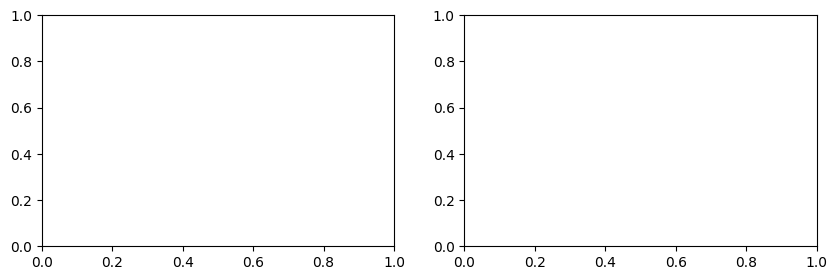

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(10, 3))
ax = ax.ravel()
for i, met in enumerate(['accuracy', 'loss']):
    ax[i].plot(hist.history[met])
    ax[i].plot(hist.history['val_'+met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])
plt.show()

In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix
preds = model.predict(test_data)
acc = accuracy_score(test_label, np.round(preds))*100
cm = confusion_matrix(test_label, np.round(preds))
tn, fp, fn, tp = cm.ravel()

In [ ]:
print('Confution Matrix ------------------------')
precition = tp/(tp+fp)*100
recall = tp/(tp+fn)*100
print('Accuracy: {}'.format(acc))
print('Precition: {}'.format(precition))
print('Recall: {}'.format(recall))
print('F1-score: {}'.format(2*precition*recall/(precition+recall)))

print('\nTrain Metric ------------------------')
print('Train acc: {}'.format(np.round((hist.history['accuracy'][-1])*100, 2)))

In [ ]:
from keras.utils import plot_model
plot_model(model, 'Model.jpg', show_shapes=2)

NameError: name 'model' is not defined